### 1. Read data into dataframe

In [1]:
import numpy as np
import pandas as pd
import json

data = pd.read_csv('../data/updated_transcripts_with_emotions_final.csv')

# Remove talks with missing transcripts/emotions
data = data[~data['detected_emotion'].isna()]

C:\Users\chris\AppData\Local\Temp\ipykernel_57172\2484526919.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 2. Extract and structure topics and emotions

In [2]:
# Extract topics into 2D list
topics = [
            json.loads(
                row.replace(' \'', ' \"').replace('\',', '\",').replace('[\'', '[\"').replace('\']', '\"]')
                )
                for row in data['topics_list']
]
topics[:2]

[['culture',
  'design',
  'business',
  'entertainment',
  'software',
  'storytelling',
  'communication',
  'community'],
 ['climate change',
  'culture',
  'environment',
  'global issues',
  'science',
  'sustainability',
  'technology',
  'transportation',
  'renewable energy']]

In [3]:
# Extract emotions into 2D list
emotions_dicts = [
            str(row).replace('\r\n', '').replace(' ', '').replace('```', '').replace('json', '')
            for row in data['detected_emotion']
]
emotions = []
bad_dicts = []
for d in emotions_dicts:
    try:
        this_emotions = list(json.loads(d).keys())
    except:
        this_emotions = []
        bad_dicts.append(d)
    emotions.append(this_emotions)
emotions[:10]

[['Inspired', 'Moved', 'Sad'],
 ['Inspired', 'Curious', 'Moved'],
 ['Curious', 'Informed', 'Impressed'],
 ['Inspired', 'Moved', 'Informed'],
 ['Moved', 'Inspired', 'Curious'],
 ['Inspired', 'Curious', 'Moved'],
 ['Moved', 'Hopeful', 'Informed'],
 ['Inspired', 'Hopeful', 'Moved'],
 ['Informed', 'Curious', 'Hopeful'],
 ['Inspired', 'Moved', 'Hopeful']]

In [4]:
len(topics), len(emotions)

(4983, 4983)

### 3. Create topic-emotion pairs. These are our "transactions".

In [5]:
pairs = []

for talk in range(len(topics)):
    talk_topics = topics[talk]
    talk_emotions = emotions[talk]

    n = len(talk_topics)
    m = len(talk_emotions)

    if n == 0 or m == 0:
        continue

    for topic in talk_topics:
        for emotion in talk_emotions:
            pairs.append([topic, emotion])

print(f"Number of Pairs: {len(pairs)}")
pairs[:10]

Number of Pairs: 110517


[['culture', 'Inspired'],
 ['culture', 'Moved'],
 ['culture', 'Sad'],
 ['design', 'Inspired'],
 ['design', 'Moved'],
 ['design', 'Sad'],
 ['business', 'Inspired'],
 ['business', 'Moved'],
 ['business', 'Sad'],
 ['entertainment', 'Inspired']]

### 4. Let's run Apriori association rule mining on just the emotions set to explore trends in the emotion mining process.

In [6]:
emotions[:10]

[['Inspired', 'Moved', 'Sad'],
 ['Inspired', 'Curious', 'Moved'],
 ['Curious', 'Informed', 'Impressed'],
 ['Inspired', 'Moved', 'Informed'],
 ['Moved', 'Inspired', 'Curious'],
 ['Inspired', 'Curious', 'Moved'],
 ['Moved', 'Hopeful', 'Informed'],
 ['Inspired', 'Hopeful', 'Moved'],
 ['Informed', 'Curious', 'Hopeful'],
 ['Inspired', 'Moved', 'Hopeful']]

In [7]:
from association_functions import extract_rules

rules, support, confidence, lift = extract_rules(emotions, 0.01, 0.01)
df = pd.DataFrame({'Rules': rules, 'Support': support, 'Confidence': confidence})
len(df)

68

##### Picking low support and confidence thresholds of 0.01, the number of rules remains a reasonable 68. Let's examine the strongest rules at these thresholds in terms of support and confidence.

In [8]:
df.sort_values(by=['Support'], ascending=False).head(15)

,Rules,Support,Confidence
6,[Inspired],0.898455,0.898455
1,[Curious],0.626330,0.626330
25,"[Inspired, Curious]",0.562713,0.626312
24,"[Curious, Inspired]",0.562713,0.898430
7,[Moved],0.511339,0.511339
59,"[Moved, Inspired]",0.465182,0.909733
58,"[Inspired, Moved]",0.465182,0.517757
3,[Hopeful],0.338551,0.338551
43,"[Inspired, Hopeful]",0.300221,0.334152
42,"[Hopeful, Inspired]",0.300221,0.886781


In [9]:
df.sort_values(by=['Confidence'], ascending=False).head(15)

,Rules,Support,Confidence
34,"[Fulfilled, Inspired]",0.053783,0.964029
14,"[Amused, Inspired]",0.051174,0.930657
59,"[Moved, Inspired]",0.465182,0.909733
6,[Inspired],0.898455,0.898455
24,"[Curious, Inspired]",0.562713,0.898430
42,"[Hopeful, Inspired]",0.300221,0.886781
63,"[Surprised, Inspired]",0.029902,0.856322
61,"[Sad, Inspired]",0.030504,0.808511
10,"[Amused, Curious]",0.042745,0.777372
48,"[Impressed, Inspired]",0.168975,0.745133


##### The 'Inspired' emotion is by far the dominant emotion, being a top 3 emotion in almost 90% of the TED Talks. The prevalence of the 'Inspired' emotion also affects which rules have the highest confidence. If we start with any other top emotion, the chance of 'Inspired' also being a top emotion is high simply due to the fact that most TED Talks have 'Inspired' as an emotion. Thus, it is expected that rules of the form (emotion &rarr; 'Inspired') will have high confidence.

##### The dominance of 'Inspired' will also affect the confidence of (topic &rarr; emotion) rules in a similar manner, so our analysis must account for that. That is, high confidence of (topic &rarr; 'Inspired') rules may be more indicative of the nature of the dataset rather than the relationship between topic and emotion.

### 5. Now let's run Apriori association rule mining on (topic, emotion) pairs to explore relationships between topics and emotions.

In [10]:
pairs[:10]

[['culture', 'Inspired'],
 ['culture', 'Moved'],
 ['culture', 'Sad'],
 ['design', 'Inspired'],
 ['design', 'Moved'],
 ['design', 'Sad'],
 ['business', 'Inspired'],
 ['business', 'Moved'],
 ['business', 'Sad'],
 ['entertainment', 'Inspired']]

In [13]:
rules, support, confidence, lift = extract_rules(pairs, 0.001, 0.1, True)
df = pd.DataFrame({'Rules': rules, 'Support': support, 'Confidence': confidence})
len(df)

205

In [14]:
df.sort_values(by=['Support'], ascending=False).head(15)

,Rules,Support,Confidence
144,"[science, Inspired]",0.009564,0.288798
150,"[technology, Inspired]",0.009184,0.303166
47,"[science, Curious]",0.008352,0.252186
52,"[technology, Curious]",0.007546,0.249104
84,"[TED-Ed, Inspired]",0.006985,0.285820
89,"[animation, Inspired]",0.006433,0.289377
102,"[culture, Inspired]",0.006415,0.301574
4,"[TED-Ed, Curious]",0.006271,0.256572
107,"[education, Inspired]",0.005872,0.291031
7,"[animation, Curious]",0.005746,0.258445


In [15]:
df.sort_values(by=['Confidence'], ascending=False).head(15)

,Rules,Support,Confidence
116,"[gender, Inspired]",0.001131,0.318066
128,"[leadership, Inspired]",0.001565,0.316850
101,"[creativity, Inspired]",0.003113,0.315018
104,"[design, Inspired]",0.004805,0.314947
111,"[equality, Inspired]",0.001773,0.312600
87,"[activism, Inspired]",0.002850,0.312500
91,"[art, Inspired]",0.003185,0.311780
115,"[future, Inspired]",0.003257,0.311688
90,"[architecture, Inspired]",0.001022,0.311295
154,"[work, Inspired]",0.001819,0.310185


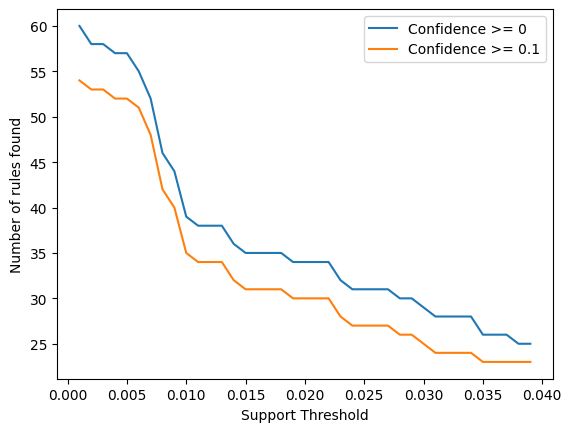

In [111]:
import matplotlib.pyplot as plot

support = np.arange(0.001, 0.04, 0.001)
rules0 = np.empty_like(support)
rules1 = np.empty_like(support)
for i, sup in enumerate(support):
    rules0[i] = len(extract_rules(emotions, sthresh = sup, cthresh = 0)[0])
    rules1[i] = len(extract_rules(emotions, sthresh = sup, cthresh = 0.1)[0])

plot.plot(support, rules0, label='Confidence >= 0')
plot.plot(support, rules1, label='Confidence >= 0.1')
plot.xlabel('Support Threshold')
plot.ylabel('Number of rules found')
plot.legend()